<a href="https://colab.research.google.com/github/cosmo-001/TimeSeriesTransformer/blob/main/TimeSeriesTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import statsmodels
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers


**Data pre-processing**

In [ ]:
df = pd.read_csv("/content/sample_data/GlobalTemperatures.csv")
#df['dt'] = pd.to_datetime(df.dt)
df.dropna(inplace=True)
#df.set_index('dt',inplace=True)
df['year'] = pd.to_datetime(df['dt']).dt.strftime('%Y')
df_train= df[df['year']<"2000"]
df_test= df[df['year']>="2000"]
df2 = df[['year', 'LandAverageTemperature']]
avg_temp_train = df_train['LandAverageTemperature'].tolist()
avg_temp_test = df_test['LandAverageTemperature'].tolist()
print(df2)


      year  LandAverageTemperature
1200  1850                   0.749
1201  1850                   3.071
1202  1850                   4.954
1203  1850                   7.217
1204  1850                  10.004
...    ...                     ...
3187  2015                  14.755
3188  2015                  12.999
3189  2015                  10.801
3190  2015                   7.433
3191  2015                   5.518

[1992 rows x 2 columns]


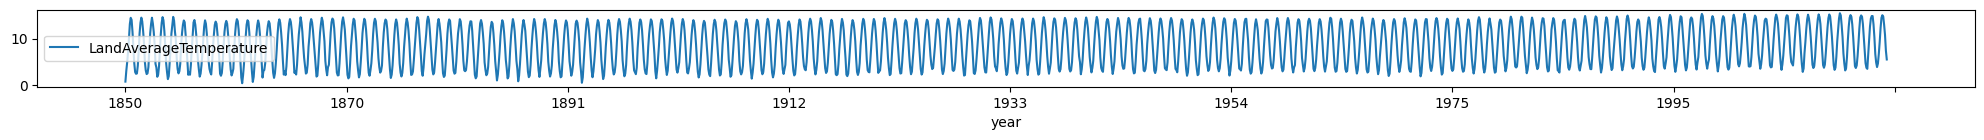

In [ ]:
import matplotlib.pyplot as plt

df2.plot(x='year', y='LandAverageTemperature', kind='line', figsize=(25, 1))
plt.show()

In [ ]:
def to_sequences(seq_size, obs):  #takes a portion of x values and predicts the value of y
    x = []
    y = []

    for i in range(len(obs) - SEQUENCE_SIZE):
        # print(i)
        window = obs[i:(i + SEQUENCE_SIZE)]
        after_window = obs[i + SEQUENCE_SIZE]
        window = [[x] for x in window]
        # print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)


SEQUENCE_SIZE = 10
x_train, y_train = to_sequences(SEQUENCE_SIZE, avg_temp_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, avg_temp_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))
print(x_train.shape)

Shape of training set: (1790, 10, 1)
Shape of test set: (182, 10, 1)
(1790, 10, 1)


In [ ]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0): #head_size = number of dimensions coming in
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs #residual connection

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

**Training the model**

In [ ]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/50
23/23 [==============================] - 12s 223ms/step - loss: 46.3469 - val_loss: 30.9914
Epoch 2/50
23/23 [==============================] - 3s 142ms/step - loss: 35.6066 - val_loss: 22.1732
Epoch 3/50
23/23 [==============================] - 3s 145ms/step - loss: 31.9361 - val_loss: 17.6499
Epoch 4/50
23/23 [==============================] - 4s 198ms/step - loss: 27.0220 - val_loss: 14.4847
Epoch 5/50
23/23 [==============================] - 3s 145ms/step - loss: 25.2417 - val_loss: 11.8330
Epoch 6/50
23/23 [==============================] - 3s 145ms/step - loss: 20.6585 - val_loss: 9.5977
Epoch 7/50
23/23 [==============================] - 4s 170ms/step - loss: 18.4061 - val_loss: 7.5046
Epoch 8/50
23/23 [==============================] - 4s 165ms/step - loss: 15.7332 - val_loss: 6.1208
Epoch 9/50
23/23 [==============================] - 3s 143ms/step - loss: 15.2251 - val_loss: 5.0936
Epoch 10/50
23/23 [==============================] - 3s 141ms/step - loss: 14.2984 - 

0.12489218264818192

**Evaluation**


In [ ]:
from sklearn import metrics


#pred = model.predict()
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

predictions = pred.tolist()
true_values = y_test.tolist()


6/6 [==============================] - 1s 26ms/step
Score (RMSE): 0.35340089411626224


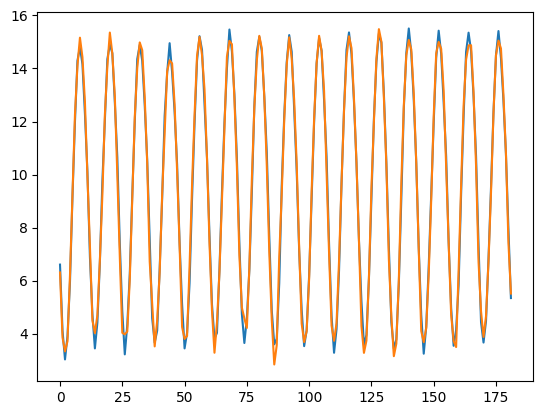

In [ ]:
import matplotlib.pyplot as plt

# create some example data


# plot the data as a line graph
plt.plot(predictions, label='Predicted') #blue = prediction
plt.plot(true_values, label='True')      #orange = true values
#plt.legend(loc="best")
plt.show()

In [ ]:

print("Prediction:",pred)

Prediction: [[ 6.6082606]
 [ 4.1204777]
 [ 3.0339718]
 [ 3.9161415]
 [ 5.9558363]
 [ 9.173512 ]
 [11.999036 ]
 [14.293645 ]
 [14.809637 ]
 [14.163307 ]
 [12.297188 ]
 [10.108052 ]
 [ 6.9084077]
 [ 4.739583 ]
 [ 3.4488945]
 [ 4.42643  ]
 [ 6.696349 ]
 [ 9.736074 ]
 [12.049323 ]
 [14.349802 ]
 [14.902451 ]
 [14.578859 ]
 [12.729366 ]
 [10.656433 ]
 [ 7.4027863]
 [ 4.838527 ]
 [ 3.2247787]
 [ 4.336769 ]
 [ 6.254229 ]
 [ 9.215782 ]
 [11.986014 ]
 [14.354906 ]
 [14.8903475]
 [14.294004 ]
 [12.620403 ]
 [10.544472 ]
 [ 7.620043 ]
 [ 4.585949 ]
 [ 3.665741 ]
 [ 4.1184087]
 [ 6.448083 ]
 [ 9.115545 ]
 [12.209835 ]
 [13.818346 ]
 [14.953678 ]
 [13.852285 ]
 [12.357979 ]
 [10.388888 ]
 [ 7.4275465]
 [ 5.1151485]
 [ 3.4493706]
 [ 4.0422454]
 [ 5.908185 ]
 [ 9.1043   ]
 [11.926663 ]
 [14.300718 ]
 [15.215735 ]
 [14.70006  ]
 [12.639703 ]
 [10.632422 ]
 [ 7.713463 ]
 [ 5.1032248]
 [ 3.8183618]
 [ 4.035162 ]
 [ 6.403793 ]
 [ 9.321152 ]
 [11.94744  ]
 [14.003975 ]
 [15.468382 ]
 [14.645139 ]
 [13.025

In [ ]:
print("Actual Temp: ", y_test)

Actual Temp:  [ 6.312  3.863  3.336  3.72   6.208  9.245 12.271 14.11  15.161 14.427
 12.736  9.935  7.319  4.507  4.026  4.704  6.772  9.229 12.248 14.084
 15.354 14.56  12.95   9.988  6.892  4.038  3.981  4.085  6.048  9.154
 12.153 14.017 14.983 14.691 12.911 10.424  6.727  5.133  3.525  4.499
  6.321  9.249 11.571 13.889 14.312 14.188 12.642 10.127  7.315  4.257
  3.808  3.92   6.544  9.618 12.226 14.476 15.19  14.51  13.217 10.601
  7.423  4.878  3.286  4.43   6.329  9.055 11.786 14.443 15.042 14.913
 12.875 10.289  6.955  4.987  4.579  4.221  6.485  9.823 12.518 14.309
 15.23  14.752 12.93  10.332  7.084  4.523  2.844  3.576  6.906  9.295
 12.054 14.145 15.174 14.377 12.802 10.399  7.224  4.385  3.687  4.094
  6.086  9.367 12.112 14.201 15.231 14.655 13.153 10.136  7.031  4.31
  3.737  4.399  6.738  9.671 12.406 14.421 15.213 14.768 12.863 10.442
  7.487  4.292  3.282  3.743  6.101  9.483 11.986 14.37  15.482 15.012
 12.912 10.352  6.814  4.655  3.157  3.628  6.023  9.676 12.59  

In [ ]:
# Specify the number of future years to predict
num_years = 10  # Replace with the desired number of years to predict

# Get the latest year in the dataset
latest_year = int(df['year'].max())

# Prepare future data for prediction
future_years = [str(year) for year in range(latest_year + 1, latest_year + num_years + 1)]
df_future = pd.DataFrame({'year': future_years})
future_avg_temp = df[df['year'] < str(latest_year)]['LandAverageTemperature'].tolist()

# Create input sequence for prediction
x_future = np.array(future_avg_temp[-SEQUENCE_SIZE:]).reshape(1, SEQUENCE_SIZE, 1)

# Predict future temperatures
predictions = []
for _ in range(num_years):
    prediction = model.predict(x_future)[0][0]
    predictions.append(prediction)
    future_avg_temp.append(prediction)
    x_future = np.array(future_avg_temp[-SEQUENCE_SIZE:]).reshape(1, SEQUENCE_SIZE, 1)

# Print the predictions
print("Predictions for the next {} years:".format(num_years))
for year, prediction in zip(future_years, predictions):
    print("Year {}: {:.2f}".format(year, prediction))


1/1 [==============================] - 0s 23ms/step
Predictions for the next 10 years:
Year 2016: 3.67
Year 2017: 4.35
Year 2018: 6.57
Year 2019: 9.35
Year 2020: 12.32
Year 2021: 14.46
Year 2022: 15.42
Year 2023: 14.65
Year 2024: 12.80
Year 2025: 10.52
